# L2 - Contextualized Token Embeddings

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> file:</b> To access <code>requirements.txt</code> for this notebook, 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

## GloVe word embeddings

In [3]:
import gensim.downloader as api
word_vectors = api.load('glove-wiki-gigaword-100')
#word_vectors = api.load('word2vec-google-news-300')

[=========-----------------------------------------] 18.3% 23.4/128.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=======================---------------------------] 46.6% 59.7/128.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=====================================-------------] 74.5% 95.4/128.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 128.1/128.1MB downloaded


In [4]:
word_vectors['king'].shape

(100,)

In [5]:
word_vectors['king'][:20]

array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
       -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
       -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
       -0.58324 ,  0.66869 ], dtype=float32)

In [6]:
# Words to visualize
words = ["king", "princess", "monarch", "throne", "crown", 
         "mountain", "ocean", "tv", "rainbow", "cloud", "queen"]

# Get word vectors
vectors = np.array([word_vectors[word] for word in words])

In [7]:
# Reduce dimensions using PCA
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(vectors)

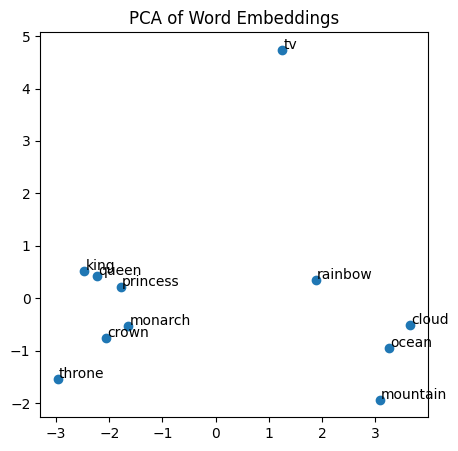

In [8]:
# Plotting
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.scatter(vectors_pca[:, 0], vectors_pca[:, 1])

for i, word in enumerate(words):
    axes.annotate(word, (vectors_pca[i, 0]+.02, vectors_pca[i, 1]+.02))
    
axes.set_title('PCA of Word Embeddings')
plt.show()

## Word2Vec algebra

In [29]:
pos_x = 'actor'
pos_y = 'male'
neg_x = 'female'
result = word_vectors.most_similar(positive=[pos_x, pos_y], 
                                   negative=[neg_x], topn=1)

# Output the result
print(f"""The word closest to '{pos_x}' - '{pos_y}' + '{neg_x}' is: '{result[0][0]}' with a similarity score of {result[0][1]}""")

The word closest to 'actor' - 'male' + 'female' is: 'actress' with a similarity score of 0.773386538028717


## GloVe vs BERT: words in context

In [31]:
# tokenizer = BertTokenizer.from_pretrained('./models/bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")

# model = BertModel.from_pretrained('./models/bert-base-uncased')
model = BertModel.from_pretrained("google-bert/bert-base-uncased")

# Function to get BERT embeddings
def get_bert_embeddings(sentence, word):
    
    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors='pt') # return Pytorch tensors
    
    # Get the model's output and last hidden state
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state

    # Tokenize the input sentence
    word_tokens = tokenizer.tokenize(sentence)

    # Index token of the input word
    word_index = word_tokens.index(word)
    
    # Embedding of the index token
    word_embedding = last_hidden_states[0, word_index + 1, :]  # +1 to account for [CLS] token
    
    return word_embedding

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [33]:
# sentence1 = "The bat flew out of the cave at night."
# sentence2 = "He swung the bat and hit a home run."

sentence1 = "The cocks are fighting in the yard."
sentence2 = "He flashed out his hard cock in front of the crowd."

# word = "bat"
word = "cock"

bert_embedding1 = get_bert_embeddings(sentence1, word).detach().numpy()
bert_embedding2 = get_bert_embeddings(sentence2, word).detach().numpy()
word_embedding = word_vectors[word]

In [35]:
print(f"BERT Embedding for '{word}' in sentence 1:", bert_embedding1[:5])
print(f"BERT Embedding for '{word}' in sentence 2:", bert_embedding2[:5])
print(f"GloVe Embedding for '{word}':", word_embedding[:5])

bert_similarity = cosine_similarity([bert_embedding1], [bert_embedding2])[0][0]
word_embedding_similarity = cosine_similarity([word_embedding], [word_embedding])[0][0]

print('-' * 100)
print(f"Cosine Similarity between BERT embeddings in different contexts: {bert_similarity}")
print(f"Cosine Similarity between GloVe embeddings: {word_embedding_similarity}")

BERT Embedding for 'cock' in sentence 1: [ 0.97916275  1.0556964  -0.11493067 -0.20767231 -0.28219703]
BERT Embedding for 'cock' in sentence 2: [ 0.4456516   0.8888002   0.7035005  -0.88391656 -0.22603866]
GloVe Embedding for 'cock': [ 0.019767 -0.19164  -0.38615  -0.29046  -0.32092 ]
----------------------------------------------------------------------------------------------------
Cosine Similarity between BERT embeddings in different contexts: 0.3303713798522949
Cosine Similarity between GloVe embeddings: 0.9999999403953552


## Cross Encoder

In [36]:
# Predicts if a pair of sentences to "matched" together
from sentence_transformers import CrossEncoder

model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512, 
                     default_activation_function=torch.nn.Sigmoid())

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [37]:
question = "Where is the capital of France?"

# Define sentences to compare
answers = [
    "Paris is the capital of France.",
    "Paris is often called the city of light.",
    "Madrid is not the capital of France."
]

In [38]:
scores = model.predict([(question, answers[0]), (question, answers[1]),
                        (question, answers[2])])
print(scores)

most_relevant_idx = torch.argmax(torch.tensor(scores)).item()
print(f"The most relevant passage is: {answers[most_relevant_idx]}")

[0.99965715 0.05372294 0.99168867]
The most relevant passage is: Paris is the capital of France.
